# **PicoScope**: analysis of beam profile

## Preliminary operations

### Flags

In [1]:
UNZIP_DATA    = False
WAVE2NUMPY    = False
PLOT_WAVE     = False
PLOT_MAV_WAVE = False
REJECT_3SIGMA = False

### Load packages

In [2]:
import os
import ROOT
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import bokeh.palettes as palette

Welcome to JupyROOT 6.22/06


In [3]:
from ROOT import TF1
from ROOT import TCanvas, TGraph, TGraphErrors

### Settings

In [4]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size=16)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=18)   # fontsize of the figure title

## Convert waveform files to numpy array and store

### Path to data

In [5]:
USER_PATH = "/home/rocco/University/APL/Lab/"
DATA_PATH = USER_PATH + "data/beam_profile_long_101220/"

### Unzip all data archives and get number of events

In [6]:
if UNZIP_DATA:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists("data"):
            os.system("unzip data.zip -d data")
        os.chdir("../")

### Convert to numpy array

In [7]:
if WAVE2NUMPY:
    os.chdir(DATA_PATH)
    for d in os.listdir("."):
        os.chdir(d)

        if not os.path.exists(d+".npy"):
            N = len(os.listdir("./data"))
            M = 5000

            data = np.zeros((N,M),dtype=np.int16)
            for f,i in zip(os.listdir("./data"), range(N)):
                data[i,:] = np.loadtxt("./data/run_"+str(i)+"_segment_0.rpsd")
            np.save(d+".npy", data)

        os.chdir("../")

## Analysis

In [8]:
M  = 20    # moving average (MAV) filter M
SC = 33    # picoscoper center in steps

### Collect data angle

In [9]:
angles = []
events = []
err_angles = []
err_events = []

pico_step = []
pico_rad  = []
pico_deg  = []
pico_seg  = []
pico_ev   = []
pico_t    = []
pico_r    = []

pico_step_err = []
pico_rad_err  = []
pico_deg_err  = []
pico_ev_err   = []
pico_r_err    = []



os.chdir(DATA_PATH)
for d in os.listdir("."):
    # print(d)
    os.chdir(d)
    run = d.split("_")[0]
    
    #######################################################################
    # TAKE DIRECTION FROM DIR NAME
    #######################################################################
    if "DC" in d:
        sign = -1
    elif "SC" in d:
        sign = +1
    else:
        sign = 0
    #######################################################################

    #######################################################################
    # TAKE DATA FROM run FILE
    #######################################################################
    file = open("run")
    line = file.readlines()
    for l in line:
        if (l.startswith("n_segments")):
            n_seg = int(l.split('=')[1].strip())
            pico_seg.append(n_seg)
        if (l.startswith("run_time")):
            run_time = int(l.split('=')[1].strip())
    file.close()
    
    steps = sign * int(''.join(filter(lambda i: i.isdigit(), run))) - SC
    #######################################################################
    
    #######################################################################
    # TAKE DATA FROM run_BlockTimes.txt
    #######################################################################
    times  = np.loadtxt("run_BlockTimes.txt")
    blocks = times.shape[0]
    events = blocks * n_seg
    # print(times.shape)
    if times.shape != (2,):
        t  = times[-1,1] - times[0,0] - np.sum(times[1:,0]-times[:-1,1])
    else:
        t  = run_time

    pico_step.append(steps)
    pico_rad.append(steps * 0.9 * np.pi / 180.0)
    pico_deg.append(steps * 0.9)
    pico_t.append(t)
    pico_ev.append(events)
    pico_r.append(events / t * 3600)
    #######################################################################
    
    #######################################################################
    # COMPUTE ERRORS
    #######################################################################
    pico_step_err.append(0.05) # 1.0 / np.sqrt(12.0)
    pico_rad_err .append(0.05 * 0.9 * np.pi / 180.0)
    pico_deg_err .append(0.05 * 0.9)
    pico_ev_err  .append(np.sqrt(events))
    pico_r_err   .append(np.sqrt(events) / t * 3600)
    #######################################################################

    
    #######################################################################
    # TAKE DATA FROM ALL WAVEFORMS
    #######################################################################
    if WAVE2NUMPY:
        data     = np.load(d+".npy")
        data_mav = np.apply_along_axis(moving_average, 1, data, M)

        baseline_mask = np.arange(data_mav.shape[1])
        baseline_mask = ((baseline_mask<1000) | (baseline_mask>3000))

        baseline = np.sum(data_mav[:,baseline_mask], axis=1) / data_mav[:,baseline_mask].shape[1]

        data_mav_int = np.sum(data_mav, axis=1) - baseline*data_mav.shape[1]

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        data_mav_int_mean = np.mean(data_mav_int)
        data_mav_int_var  = np.std(data_mav_int)

        if REJECT_3SIGMA:
            mask_t = np.logical_and(data_mav_int<data_mav_int_mean+data_mav_int_var*3, data_mav_int>data_mav_int_mean-data_mav_int_var*3)
            mask_f = np.logical_not(mask_t)
        else:
            mask_t = np.ones(data_mav_int.shape, dtype=bool)
            mask_f = np.logical_not(mask_t)

        if PLOT_WAVE:
            fig=plt.figure(figsize=(12, 4))
            plt.subplot(1,2,1)
            if mask_f.shape[0] != 0:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
                plt.plot(np.where(mask_f)[0], data_mav_int[mask_f], "o", markersize=1.5)
            else:
                plt.plot(np.where(mask_t)[0], data_mav_int[mask_t], "o", markersize=1.5)
            plt.title(d)

            plt.subplot(1,2,2)
            if mask_f.shape[0] != 0:
                plt.hist([data_mav_int[mask_t], data_mav_int[mask_f]], bins=50, stacked=True)
            else:
                plt.hist(data_mav_int[mask_t], bins=50, stacked=True)
            plt.yscale("log")
            plt.title(d)
            plt.show()
    #######################################################################

    os.chdir(DATA_PATH)

### Events distribution

In [10]:
col = palette.brewer['RdYlGn'][10]

In [11]:
d = {
    "pico_step"     : pico_step,
    "pico_rad"      : pico_rad,
    "pico_deg"      : pico_deg,
    "pico_seg"      : pico_seg,
    "pico_ev"       : pico_ev,
    "pico_t"        : pico_t,
    "pico_r"        : pico_r,
    "pico_step_err" : pico_step_err,
    "pico_rad_err"  : pico_rad_err,
    "pico_deg_err"  : pico_deg_err,
    "pico_ev_err"   : pico_ev_err,
    "pico_r_err"    : pico_r_err
}

df = pd.DataFrame(data=d)
df = df.sort_values(by=['pico_step'])

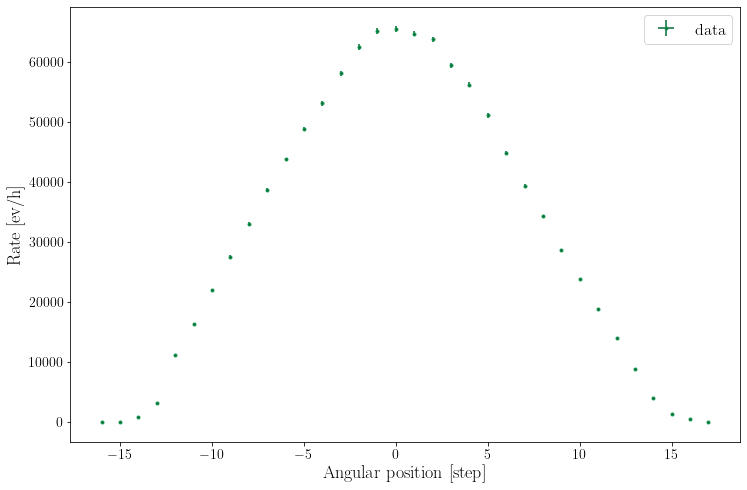

In [12]:
plt.figure(figsize=(12,8))
plt.errorbar(df["pico_step"], df["pico_r"],
             xerr=df["pico_step_err"], yerr=df["pico_r_err"],
             fmt='o', markerfacecolor=col[0],
             color=col[1], ecolor=col[0],
             label="data",alpha=1,markersize=3)
plt.xlabel("Angular position [step]")
plt.ylabel("Rate [ev/h]")
plt.legend()
plt.show()

In [13]:
np.vstack((np.round(np.array(df["pico_deg"]),2), np.array(df["pico_ev"]), np.array(df["pico_step"]))).T

array([[-1.440e+01,  1.000e+01, -1.600e+01],
       [-1.350e+01,  1.900e+01, -1.500e+01],
       [-1.260e+01,  4.100e+02, -1.400e+01],
       [-1.170e+01,  1.548e+03, -1.300e+01],
       [-1.080e+01,  5.700e+03, -1.200e+01],
       [-9.900e+00,  8.200e+03, -1.100e+01],
       [-9.000e+00,  1.100e+04, -1.000e+01],
       [-8.100e+00,  1.380e+04, -9.000e+00],
       [-7.200e+00,  1.650e+04, -8.000e+00],
       [-6.300e+00,  1.940e+04, -7.000e+00],
       [-5.400e+00,  2.000e+04, -6.000e+00],
       [-4.500e+00,  2.000e+04, -5.000e+00],
       [-3.600e+00,  2.000e+04, -4.000e+00],
       [-2.700e+00,  2.000e+04, -3.000e+00],
       [-1.800e+00,  2.000e+04, -2.000e+00],
       [-9.000e-01,  2.000e+04, -1.000e+00],
       [ 0.000e+00,  2.000e+04,  0.000e+00],
       [ 9.000e-01,  2.000e+04,  1.000e+00],
       [ 1.800e+00,  2.000e+04,  2.000e+00],
       [ 2.700e+00,  2.000e+04,  3.000e+00],
       [ 3.600e+00,  2.000e+04,  4.000e+00],
       [ 4.500e+00,  2.000e+04,  5.000e+00],
       [ 5

## Beam angular extension

In [14]:
lrange = [-13, -2]
rrange = [2, 13]

In [15]:
ldf = df[(df["pico_step"]>=lrange[0]) & (df["pico_step"]<=lrange[1])]
rdf = df[(df["pico_step"]>=rrange[0]) & (df["pico_step"]<=rrange[1])]

### Left half

In [16]:
ln  = ldf.shape[0]
lx  = ldf["pico_step"].to_numpy(dtype=np.float)
ly  = ldf["pico_r"].to_numpy(dtype=np.float)
lex = ldf["pico_step_err"].to_numpy(dtype=np.float)
ley = ldf["pico_r_err"].to_numpy(dtype=np.float)

In [17]:
lge  = TGraphErrors(ln, lx, ly, lex, ley)
lf   = TF1('lf', '[0] + [1]*x', -15, 0)
lfit = lge.Fit('lf', 'S')
lpar = [lfit.Get().Parameter(i) for i in range(2)]

 FCN=107.031 FROM MIGRAD    STATUS=CONVERGED     104 CALLS         105 TOTAL
                     EDM=1.35723e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.56069e+04   2.97502e+02   5.46835e-01  -4.23910e-07
   2  p1           5.42938e+03   3.17621e+01   5.83766e-02  -1.28288e-06


### Right half

In [18]:
rn  = rdf.shape[0]
rx  = rdf["pico_step"].to_numpy(dtype=np.float)
ry  = rdf["pico_r"].to_numpy(dtype=np.float)
rex = rdf["pico_step_err"].to_numpy(dtype=np.float)
rey = rdf["pico_r_err"].to_numpy(dtype=np.float)

In [19]:
rge  = TGraphErrors(rn, rx, ry, rex, rey)
rf   = TF1('rf', '[0] + [1]*x', -15, 0)
rfit = rge.Fit('rf', 'S')
rpar = [rfit.Get().Parameter(i) for i in range(2)]

 FCN=30.5945 FROM MIGRAD    STATUS=CONVERGED      84 CALLS          85 TOTAL
                     EDM=1.80376e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.54551e+04   3.03950e+02   2.94249e-01   5.58832e-07
   2  p1          -5.14330e+03   3.26263e+01   3.15905e-02   4.99680e-06


### Plot results

In [20]:
lxfit = np.arange(-15,1)
lyfit = lpar[0] + lpar[1] * lxfit

rxfit = np.arange(0,16)
ryfit = rpar[0] + rpar[1] * rxfit

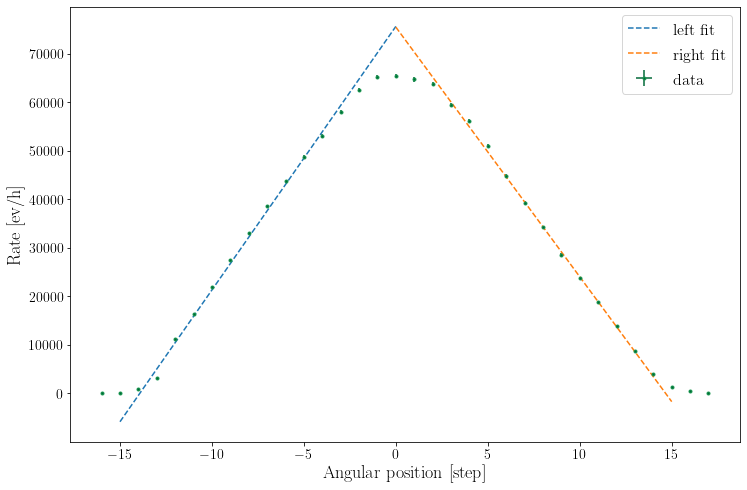

In [21]:
plt.figure(figsize=(12,8))
plt.errorbar(df["pico_step"], df["pico_r"],
             xerr=df["pico_step_err"], yerr=df["pico_r_err"],
             fmt='o', markerfacecolor=col[0],
             color=col[1], ecolor=col[0],
             label="data",alpha=1,markersize=3)
plt.plot(lxfit, lyfit, "--", label="left fit")
plt.plot(rxfit, ryfit, "--", label="right fit")
plt.xlabel("Angular position [step]")
plt.ylabel("Rate [ev/h]")
plt.legend()
plt.show()

### Estimate angular opening of beam

In [23]:
lx0 = - lpar[0] / lpar[1]
rx0 = - rpar[0] / rpar[1]

In [24]:
rx0 - lx0

28.596076559648743